In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
import collections
from array import array

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'
outputdir = inputdir+'xsec_other_2D_2_mar18/' 
output_filedir = outputdir
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')


Welcome to JupyROOT 6.18/04


In [2]:
pot_data =    7.644e+18

outputdir_png, outputdir_root, outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"xsec_genie_other_2D_2.root","RECREATE");


In [3]:
#!jupyter nbconvert --to script numuCCana_muon_cut_weight.ipynb

In [4]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# Other Genie 2D cross section error calculation

In [5]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [6]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/30.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [7]:
from array import array
#mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
#mom_bins = [ 0.00, 0.225, 0.28, 0.33, 0.39, 0.52, 0.78, 1.21, 2.5]

mom_bins = {}
mom_bins[0] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[1] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[2] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[3] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[4] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[5] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[6] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]
mom_bins[7] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]
mom_bins[8] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]

theta_bins = [ -1.00, -0.50, 0.00, 0.28, 0.47, 0.63, 0.765, 0.865, 0.935, 1.00 ]

len_theta = len(theta_bins) - 1
len_mom = {}
sum_bins = 0
for i in range(len_theta):
    len_mom[i] = len(mom_bins[i]) - 1
    #print len_mom[i]
    sum_bins+=len_mom[i]


In [8]:
#weight_list = [ 'AxFFCCQEshape_UBGenie','DecayAngMEC_UBGenie' ]
weight_list = [ 'AxFFCCQEshape_UBGenie' , 'DecayAngMEC_UBGenie', 'NormCCCOH_UBGenie', 'NormNCCOH_UBGenie',\
               'RPA_CCQE_Reduced_UBGenie','RPA_CCQE_UBGenie','ThetaDelta2NRad_UBGenie','Theta_Delta2Npi_UBGenie',\
                'VecFFCCQEshape_UBGenie','XSecShape_CCMEC_UBGenie']
num_para = len(weight_list)
print 'Nuber of parameters: ',num_para
num_universes = 2
#max_entries = 100000

Nuber of parameters:  10


In [9]:
path_other = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'
f_other = ROOT.TFile.Open(path_other+"pc46_data/Other_Genie_2D.root", 'read')

path_cv = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'
f_cv = ROOT.TFile.Open(path_cv+"xsec_filesV4/xsec_2D_wighted.root", 'read')

# fix file: root -l
#            TFile *MyFile = new TFile("All_Genie_theta.root","UPDATE");
#           MyFile->Write()

In [10]:
# get data, ext and dirt from CV file
h_data = []
h_ext = []
h_dirt = []

for t_bin in range(len_theta):
    h_data.append(f_cv.Get('h_data['+str(t_bin)+']'))
    h_ext.append(f_cv.Get('h_ext['+str(t_bin)+']'))
    h_dirt.append(f_cv.Get('h_dirt['+str(t_bin)+']'))

print h_data[0].Integral(0,len_mom[0]+1)
print h_ext[0].Integral(0,len_mom[0]+1)
print h_dirt[0].Integral(0,len_mom[0]+1)

88.0
5.80717624724
11.4282898307


In [11]:
# get background from all genie file
h_bkg = []

for para in range(num_para):
    h_bkg.append([])
    for uni in range(num_universes):
        h_bkg[para].append([])
        for t_bin in range(len_theta):
            h_bkg[para][uni].append(f_other.Get('h_overlay['+str(para)+']['+str(uni)+']['+str(t_bin)+']'))

In [12]:
# get background from all genie file
h_eff_tilde = []

for para in range(num_para):
    h_eff_tilde.append([])
    for uni in range(num_universes):
        h_eff_tilde[para].append([])
        for t_bin in range(len_theta):
            h_eff_tilde[para][uni].append(f_other.Get('h_1d_eff_tilde['+str(para)+']['+str(uni)+']['+str(t_bin)+']'))

In [13]:
# calculate xsec for each universe
h_xsec_data = []

for para in range(num_para):
    h_xsec_data.append([])
    for uni in range(num_universes):
        h_xsec_data[para].append([])
        for t_bin in range(len_theta):
            h_xsec_data[para][uni].append(h_data[t_bin].Clone())
            h_xsec_data[para][uni][t_bin].Add(h_ext[t_bin],-1)
            h_xsec_data[para][uni][t_bin].Add(h_dirt[t_bin],-1)
            h_xsec_data[para][uni][t_bin].Add(h_bkg[para][uni][t_bin],-1)

            h_xsec_data[para][uni][t_bin].Divide(h_eff_tilde[para][uni][t_bin])
            h_xsec_data[para][uni][t_bin].Scale(1.0/(N_tot*beam_flux*1e-38))

            for m_bin in range(len_mom[t_bin]):
                h_xsec_data[para][uni][t_bin].SetBinContent(m_bin+1,h_xsec_data[para][uni][t_bin].GetBinContent(m_bin+1)/h_xsec_data[para][uni][t_bin].GetBinWidth(m_bin+1))
                h_xsec_data[para][uni][t_bin].SetBinError(m_bin+1,h_xsec_data[para][uni][t_bin].GetBinError(m_bin+1)/h_xsec_data[para][uni][t_bin].GetBinWidth(m_bin+1))

            bin_width_theta = theta_bins[t_bin+1] - theta_bins[t_bin]
            h_xsec_data[para][uni][t_bin].Scale(1.0/bin_width_theta)

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_xsec_2D_0_all.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_xsec_2D_0_all.pdf has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_xsec_2D_1_all.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_xsec_2D_1_all.pdf has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_xsec_2D_2_all.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_xsec_2D_2_all.pdf has been created
Info in <T

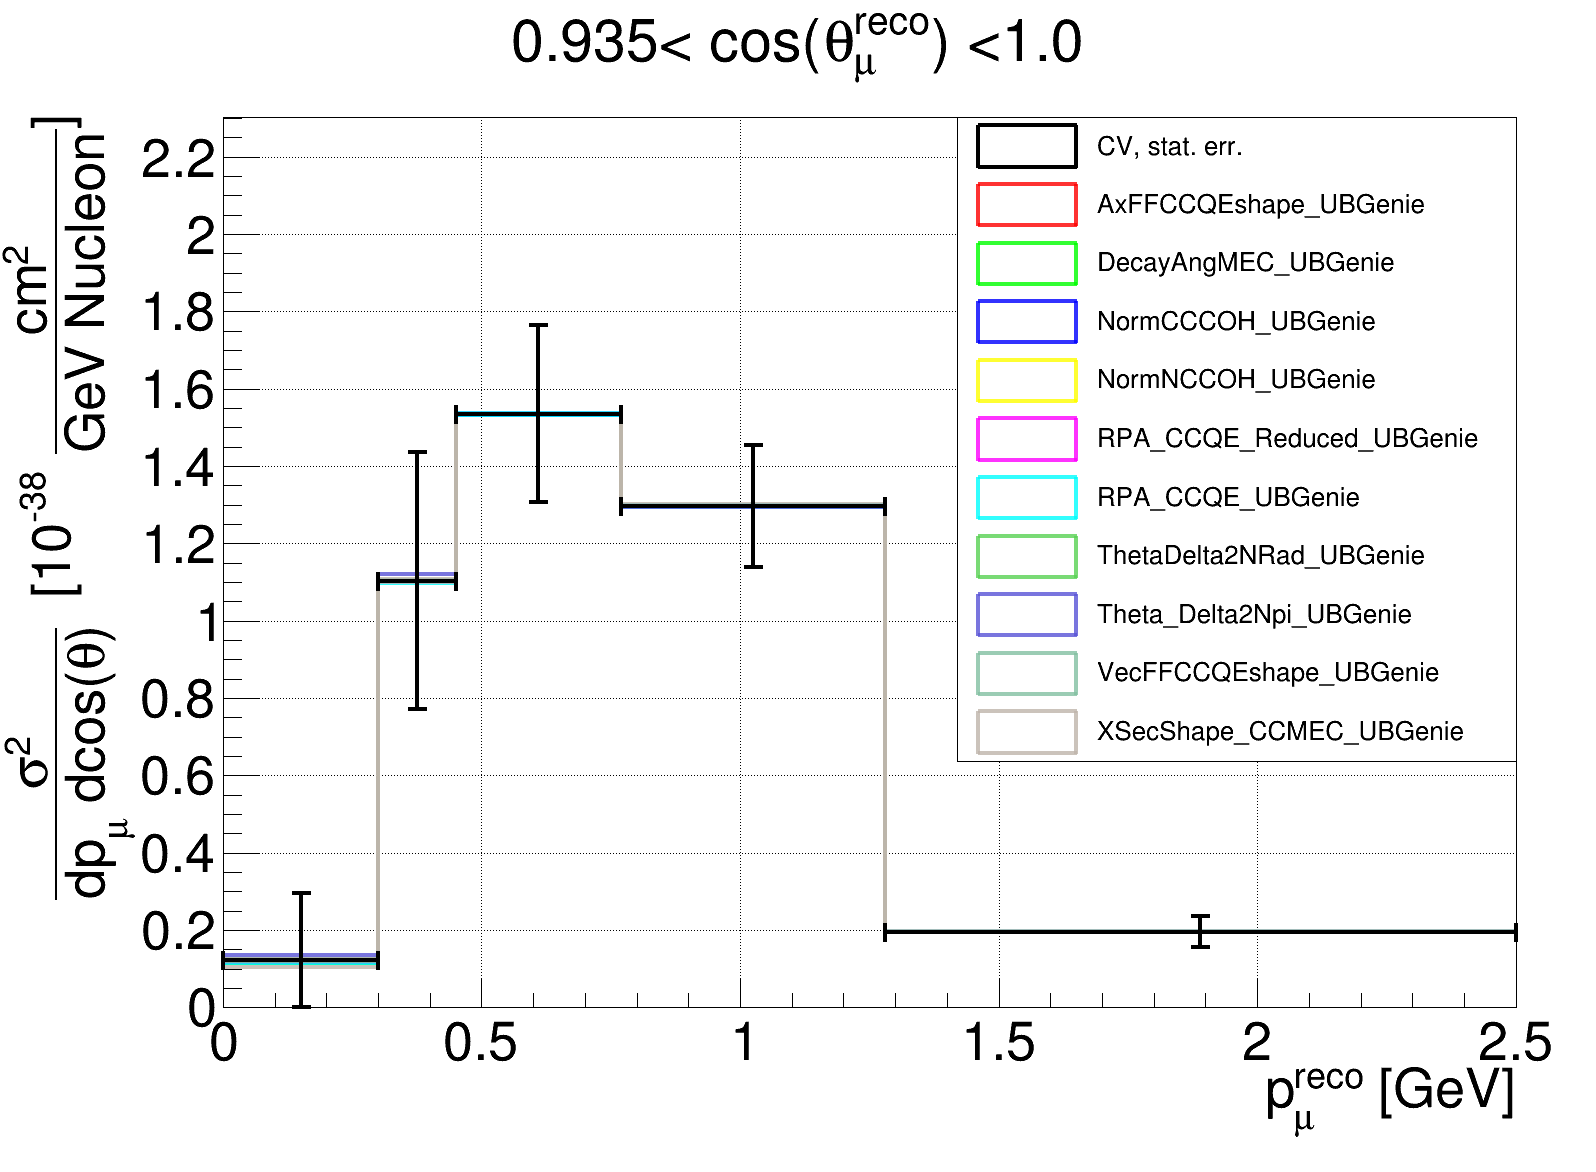

In [14]:
# draw all xsec

ROOT.gStyle.SetOptTitle(1)
ROOT.gStyle.SetEndErrorSize(9)
for t_bin in range(len_theta): #len_theta
    legend = ROOT.TLegend(0.6,0.35,0.95,0.9); #LEGEND RIGHT
    for para in range(num_para):
        for uni in range(num_universes):
            h_xsec_data[para][uni][t_bin].SetLineColorAlpha(2,0.8)
            h_xsec_data[para][uni][t_bin].GetYaxis().SetTitleSize(0.05)
            h_xsec_data[para][uni][t_bin].GetYaxis().SetTitleOffset(0.0)
            h_xsec_data[para][uni][t_bin].GetYaxis().SetLabelSize(0.05)
            h_xsec_data[para][uni][t_bin].GetXaxis().SetTitleSize(0.05)
            h_xsec_data[para][uni][t_bin].GetXaxis().SetLabelSize(0.05)
            h_xsec_data[para][uni][t_bin].GetXaxis().SetTitleOffset(1)
            h_xsec_data[para][uni][t_bin].SetLineColorAlpha(para+2,0.8)
            if para+2==10:
                h_xsec_data[para][uni][t_bin].SetLineColorAlpha(30,0.8)
            h_xsec_data[para][uni][t_bin].SetLineWidth(4)
            if(uni == 0 and para==0):
                h_xsec_data[para][uni][t_bin].SetLineColorAlpha(1,1)
                h_xsec_data[para][uni][t_bin].SetTitle(str(theta_bins[t_bin])+'< cos(#theta^{reco}_{#mu}) <'+str(theta_bins[t_bin+1]))
                h_xsec_data[para][uni][t_bin].SetXTitle("p^{reco}_{#mu} [GeV]")
                h_xsec_data[para][uni][t_bin].SetYTitle('#frac{#sigma^{2}}{dp_{#mu} dcos(#theta)} \t [10^{-38} #frac{cm^{2}}{GeV Nucleon}]')
                h_xsec_data[para][uni][t_bin].SetMaximum(-1111)
                h_xsec_data[para][uni][t_bin].SetMinimum(0)
                h_xsec_data[para][uni][t_bin].SetMaximum( h_xsec_data[para][uni][t_bin].GetMaximum()*1.5)
                h_xsec_data[para][uni][t_bin].Draw('hist')
                legend.AddEntry(h_xsec_data[para][uni][t_bin],'CV, stat. err.',"f")
            else:
                h_xsec_data[para][uni][t_bin].Draw('hist same')
        h_xsec_data[0][0][t_bin].Draw('same E1')
        legend.AddEntry(h_xsec_data[para][uni][t_bin],weight_list[para],"f")
    legend.Draw()
    c1.SaveAs(outputdir_png + 'h_xsec_2D_'+str(t_bin)+'_all.png')
    #c1.SaveAs(globale.outputdir_root + 'h_xsec_2D_'+str(t_bin)+'_all.root')
    c1.SaveAs(outputdir_pdf + 'h_xsec_2D_'+str(t_bin)+'_all.pdf')

    c1.Draw()
            


In [15]:
def plot_other_sys_histo(name):
    c1.SetRightMargin(0.05)
    c1.SetLeftMargin(0.18)

    ROOT.gStyle.SetOptTitle(1)
    #files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray,f_recomb2]
    #name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh', 'recomb2' ]
    #name_files = ['Central Value','Space Charge Effect','Light Yield Down','Wire Response #theta_{X}','Wire Response #theta_{YZ}','Wire Response X','Wire Response YZ','Light Attenuation','Rayleigh Scattering','Recombination']
    i = 0
    legend = ROOT.TLegend(0.18,0.55,0.45,0.9); #LEGEND RIGHT
    h_files = []
    for para in range(num_para):
        h_files.append([])
        for uni in range(num_universes): 
            h_files[para].append(f_other.Get(name+'['+str(para)+']['+str(uni)+']'))
            h_files[para][uni].SetLineColor(para+1)
            h_files[para][uni].SetLineWidth(4)
            h_files[para][uni].GetYaxis().SetTitleSize(0.05)
            h_files[para][uni].GetYaxis().SetTitleOffset(0.0)
            h_files[para][uni].GetYaxis().SetLabelSize(0.05)
            h_files[para][uni].GetXaxis().SetTitleSize(0.05)
            h_files[para][uni].GetXaxis().SetLabelSize(0.05)
            h_files[para][uni].GetXaxis().SetTitleOffset(1)
            if (para+1)==10:
                h_files[para][uni].SetLineColor(30)
            if (para == 0 and uni==0):
                h_files[para][uni].SetMaximum(-1111)
                h_files[para][uni].SetMaximum(h_files[para][uni].GetMaximum()*1.5)
                h_files[para][uni].SetTitle(name)
                h_files[para][uni].SetXTitle("Bin number")
                h_files[para][uni].SetYTitle("Number of entries")
                h_files[para][uni].Draw('hist')
                legend.Draw()
            else:
                h_files[para][uni].Draw("hist same")
        legend.AddEntry(h_files[para][uni],weight_list[para],"f")
    h_files[0][0].Draw("hist same")
    h_files[0][0].Draw("text same")
    legend.Draw()

    c1.Draw()
    del h_files[:]

    c1.SaveAs(outputdir_png +name+'.png')
    c1.SaveAs(outputdir_root +name+'.root')
    c1.SaveAs(outputdir_pdf +name+'.pdf')
    ROOT.gStyle.SetOptTitle(0)
    return

#h_files.clear()

ploting:  h_sel_all
ploting:  h_gen_all
ploting:  h_eff_all


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_sel_all.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/root/h_sel_all.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_sel_all.pdf has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_gen_all.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/root/h_gen_all.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_gen_all.pdf has been created
Info in <TCanvas::Print>: png file /ho

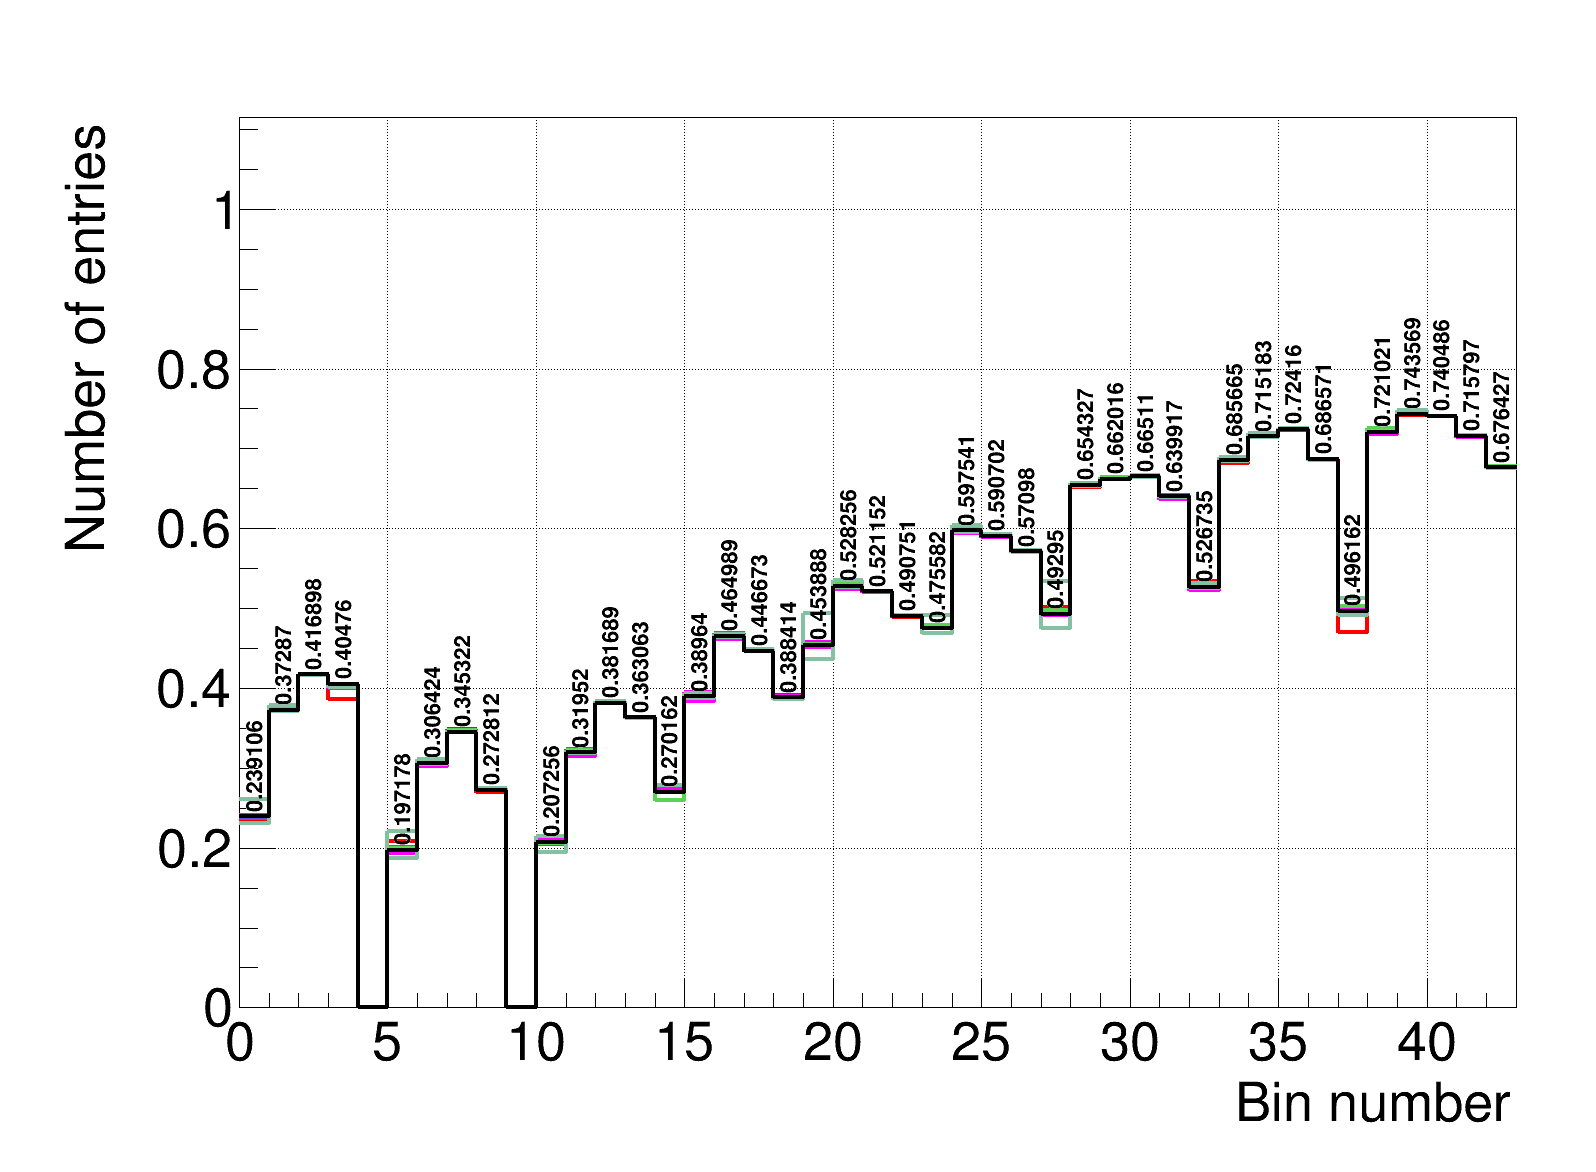

In [16]:

variable_list = ['h_sel_all','h_gen_all','h_eff_all']
for x in variable_list:
    print 'ploting: ', x
    plot_other_sys_histo(x)
c1.SetLeftMargin(0.15)

In [17]:
cov_matrix_other = np.zeros((num_para,sum_bins,sum_bins))
cov_matrix = np.zeros((sum_bins,sum_bins))
xsec_diff_matrix = np.zeros((num_para,sum_bins))
xsec_cv_vec = np.zeros((sum_bins))

for para in range(num_para):
        bin_counter = 0
        for t_bin in range(len_theta):
            #print 'next theta',t_bin
            for m_bin in range(len_mom[t_bin]):
                xsec_cv = h_xsec_data[para][0][t_bin].GetBinContent(m_bin+1)
                xsec_cv_vec[bin_counter] = xsec_cv
                xsec_other = h_xsec_data[para][1][t_bin].GetBinContent(m_bin+1)
                xsec_diff_matrix[para][bin_counter] = xsec_cv-xsec_other

                bin_counter+=1
        cov_matrix_other[para] = xsec_diff_matrix[para].reshape(sum_bins,1) * xsec_diff_matrix[para]
        cov_matrix = cov_matrix + cov_matrix_other[para] 

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_covariance_othersysAxFFCCQEshape_UBGenie.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/root/h_covariance_othersysAxFFCCQEshape_UBGenie.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_covariance_othersysAxFFCCQEshape_UBGenie.pdf has been created
Warning in <TFile::Append>: Replacing existing TH1: h_covariance (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_covariance_othersysDecayAngMEC_UBGenie.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/root/h_covaria

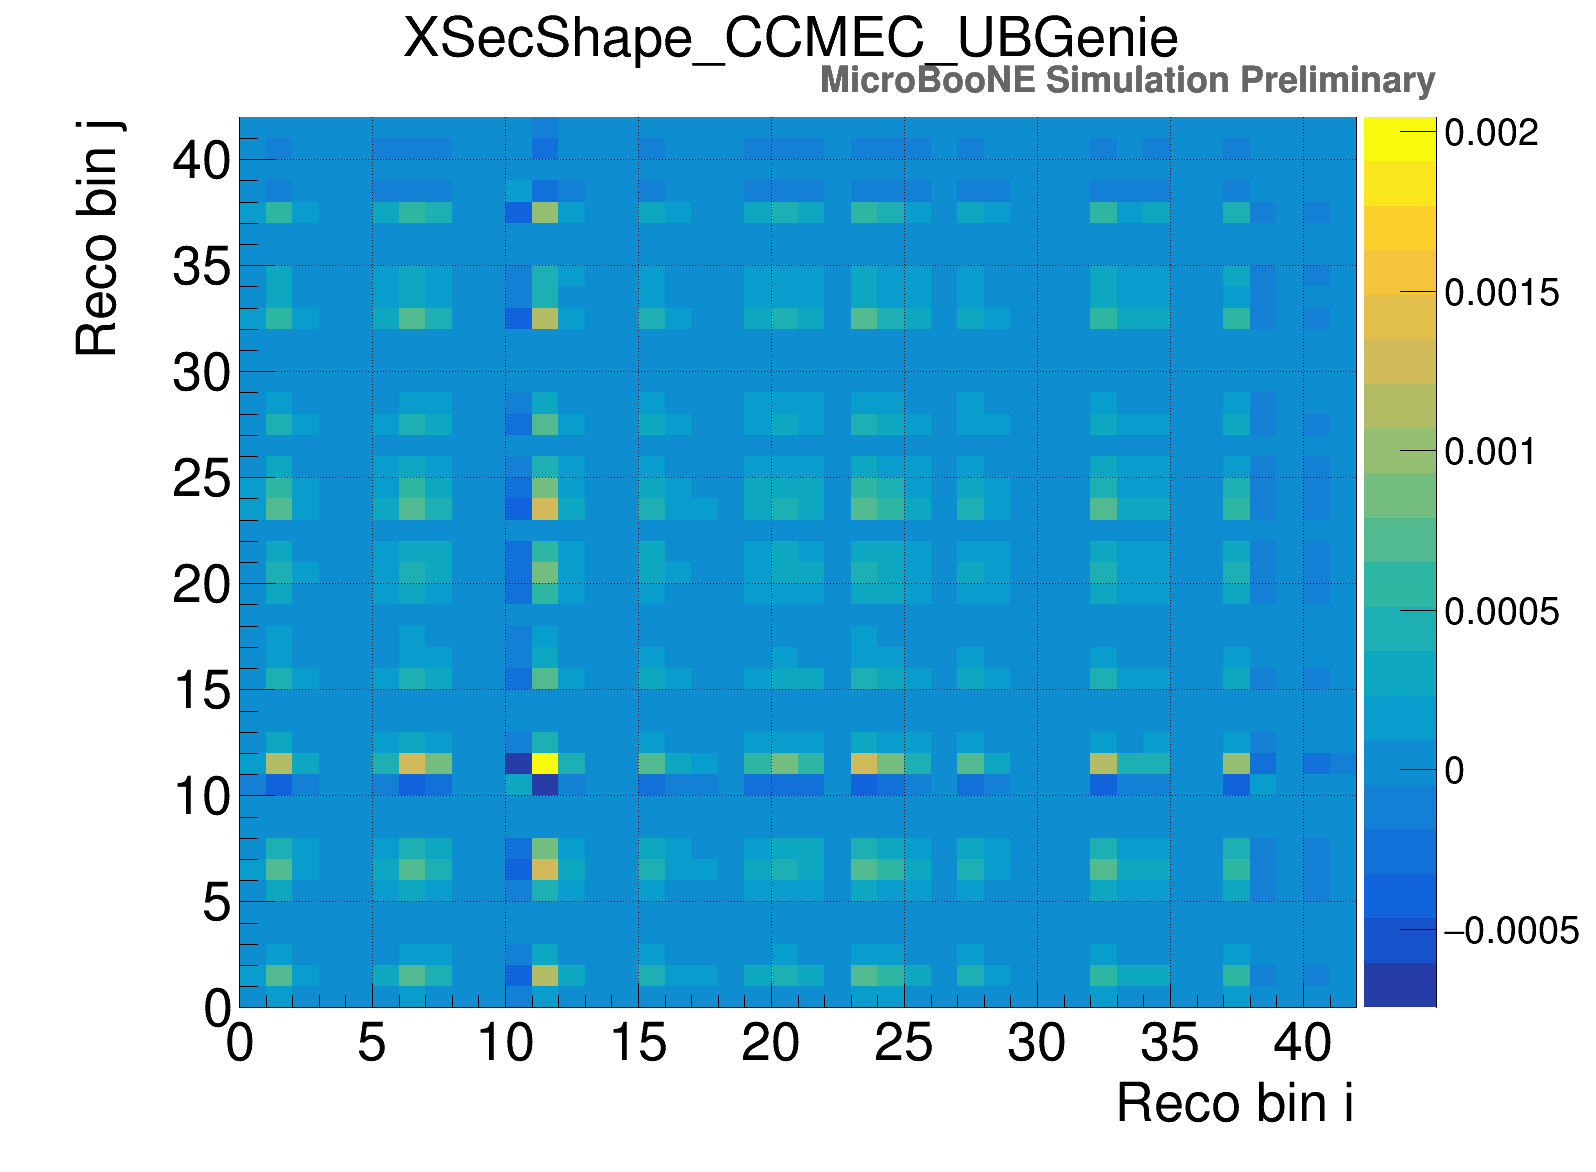

In [18]:
ROOT.gStyle.SetOptTitle(1)

for para in range(num_para):
    ROOT.gStyle.SetPaintTextFormat('0.6g')
    h_covariance = ROOT.TH2D("h_covariance",weight_list[para],sum_bins,0,sum_bins,sum_bins,0,sum_bins)
    for i in range(sum_bins):
        for j in range(sum_bins):
            h_covariance.SetBinContent(i+1,j+1,cov_matrix_other[para,i,j])
    #h_covariance.SetXTitle("Reco bin i, 7=overflow")
    #h_covariance.SetYTitle("True bin j")
    h_covariance.SetXTitle("Reco bin i")
    h_covariance.SetYTitle("Reco bin j")

    h_covariance.GetYaxis().SetTitleSize(0.05)
    h_covariance.GetYaxis().SetTitleOffset(0.0)
    h_covariance.GetYaxis().SetLabelSize(0.05)
    h_covariance.GetXaxis().SetTitleSize(0.05)
    h_covariance.GetXaxis().SetLabelSize(0.05)
    h_covariance.GetXaxis().SetTitleOffset(1)
    h_covariance.SetLineColor(ROOT.kBlack)
    h_covariance.SetLineWidth(4)
    ROOT.gStyle.SetEndErrorSize(5)
    c1.SetRightMargin(0.15)
    ROOT.gStyle.SetPaintTextFormat('0.4g')

    h_covariance.Draw('colz')
    #_covariance.Draw('same text')
    prelim = draw_sim()
    prelim.Draw()
    c1.Draw()
    c1.SaveAs(outputdir_png + 'h_covariance_othersys'+weight_list[para]+'.png')
    c1.SaveAs(outputdir_root + 'h_covariance_othersys'+weight_list[para]+'.root')
    c1.SaveAs(outputdir_pdf + 'h_covariance_othersys'+weight_list[para]+'.pdf')
    #h_covariance.Write('h_covariance')
        

Warning in <TFile::Append>: Replacing existing TH1: h_covariance (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_covariance_othersys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/root/h_covariance_othersys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_covariance_othersys.pdf has been created


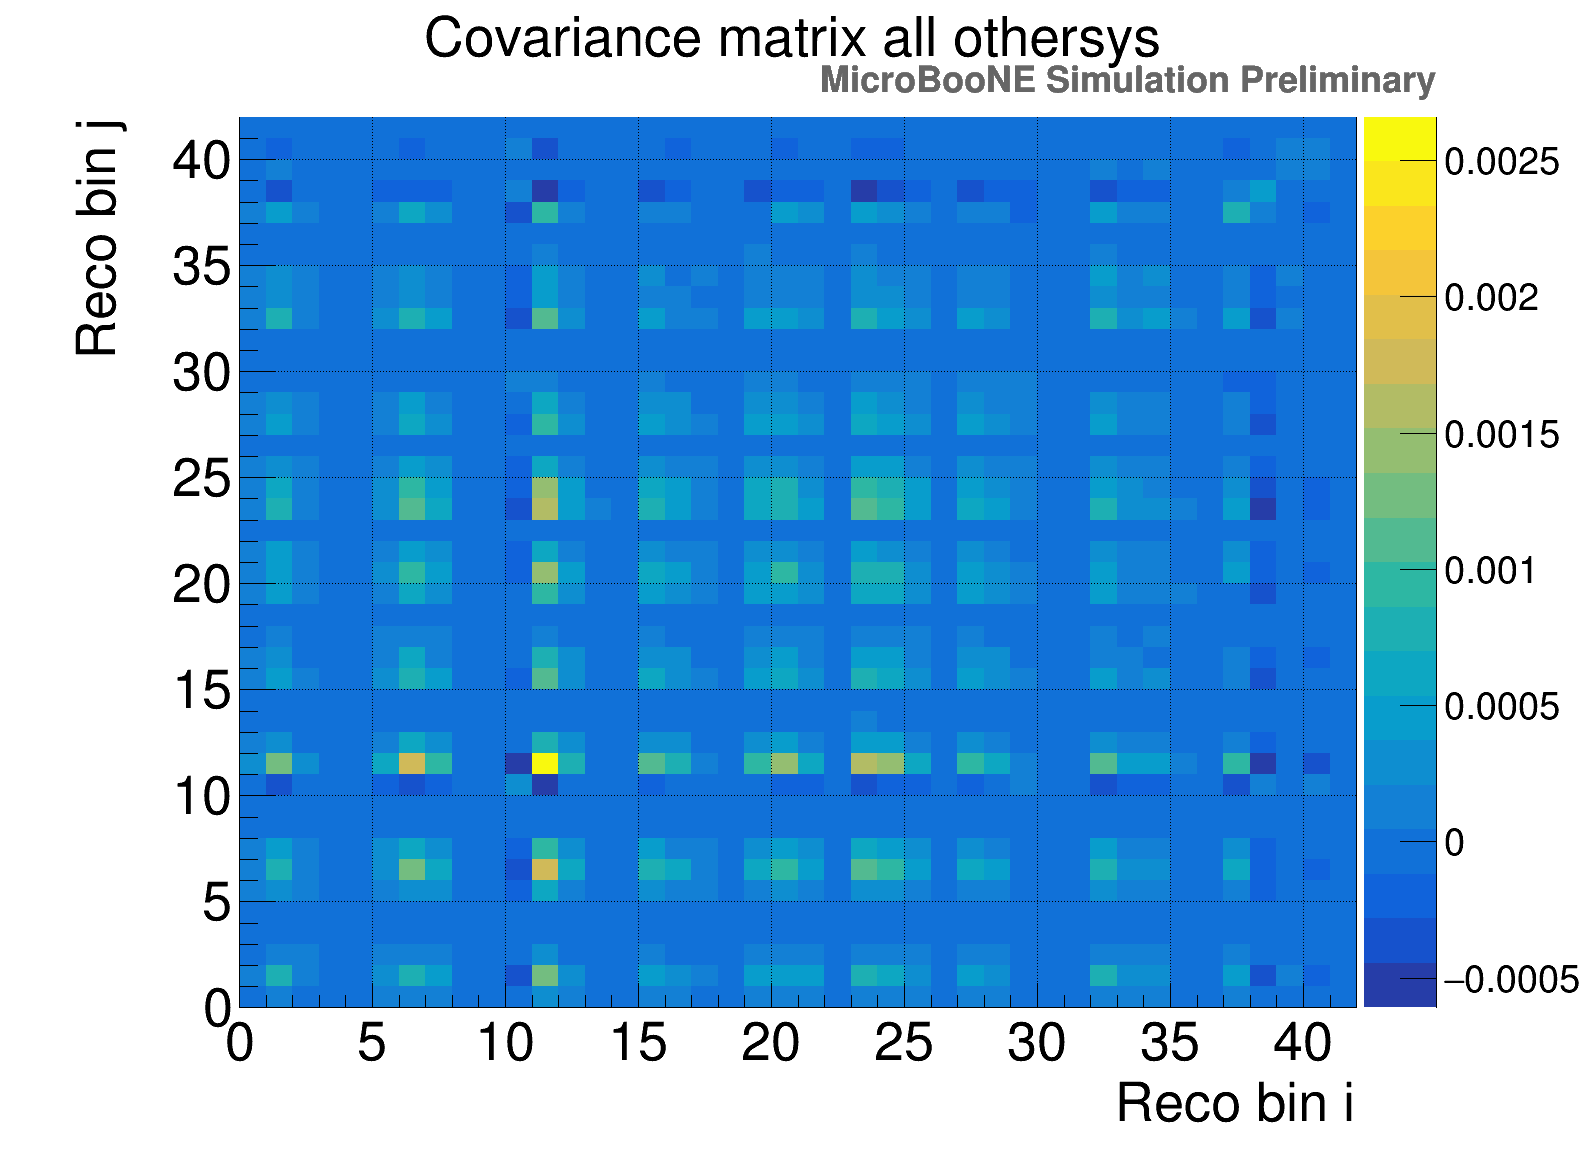

In [19]:
ROOT.gStyle.SetPaintTextFormat('0.6g')
h_covariance = ROOT.TH2D("h_covariance",'Covariance matrix all othersys',sum_bins,0,sum_bins,sum_bins,0,sum_bins)
for i in range(sum_bins):
    for j in range(sum_bins):
        h_covariance.SetBinContent(i+1,j+1,cov_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")

h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.15)
ROOT.gStyle.SetPaintTextFormat('0.4g')

h_covariance.Draw('colz')
#h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_covariance_othersys.png")
c1.SaveAs(outputdir_root + "h_covariance_othersys.root")
c1.SaveAs(outputdir_pdf + "h_covariance_othersys.pdf")
#h_covariance.Write('h_covariance')
RootFile = ROOT.TFile(output_filedir+"Other_systematic_2D.root","recreate");
h_covariance.Write('h_covariance')
RootFile.Close()  

In [20]:
#correlation matrix
xsec_corr_matrix = np.zeros((sum_bins,sum_bins))
for i in range(sum_bins):
    for j in range(sum_bins):
        xsec_corr_matrix[i][j] = cov_matrix[i][j]/(1e-80+math.sqrt(cov_matrix[i][i]*cov_matrix[j][j]))

#correlation matrix per detsys  
xsec_corr_matrix_other = np.zeros((num_para,sum_bins,sum_bins))
for para in range(num_para):
    for i in range(sum_bins):
        for j in range(sum_bins):
            xsec_corr_matrix_other[para][i][j] = cov_matrix_other[para][i][j]/(1e-80+math.sqrt(cov_matrix_other[para][i][i]*cov_matrix_other[para][j][j]))


In [21]:
#frac covariance matrix
xsec_frac_matrix = np.zeros((sum_bins,sum_bins))
for i in range(sum_bins):
    for j in range(sum_bins):
        #print cov_matrix[i][j]
        xsec_frac_matrix[i][j] = cov_matrix[i][j]/(1e-80+(xsec_cv_vec[i]*xsec_cv_vec[j]))

#correlation matrix per detsys  
xsec_frac_matrix_other = np.zeros((num_para,sum_bins,sum_bins))
for para in range(num_para):
    for i in range(sum_bins):
        for j in range(sum_bins):
            xsec_frac_matrix_other[para][i][j] = cov_matrix_other[para][i][j]/(1e-80+(xsec_cv_vec[i]*xsec_cv_vec[j]))


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_correlation_othersysAxFFCCQEshape_UBGenie.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/root/h_correlation_othersysAxFFCCQEshape_UBGenie.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_correlation_othersysAxFFCCQEshape_UBGenie.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_covariance (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_correlation_othersysDecayAngMEC_UBGenie.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/root/h_cor

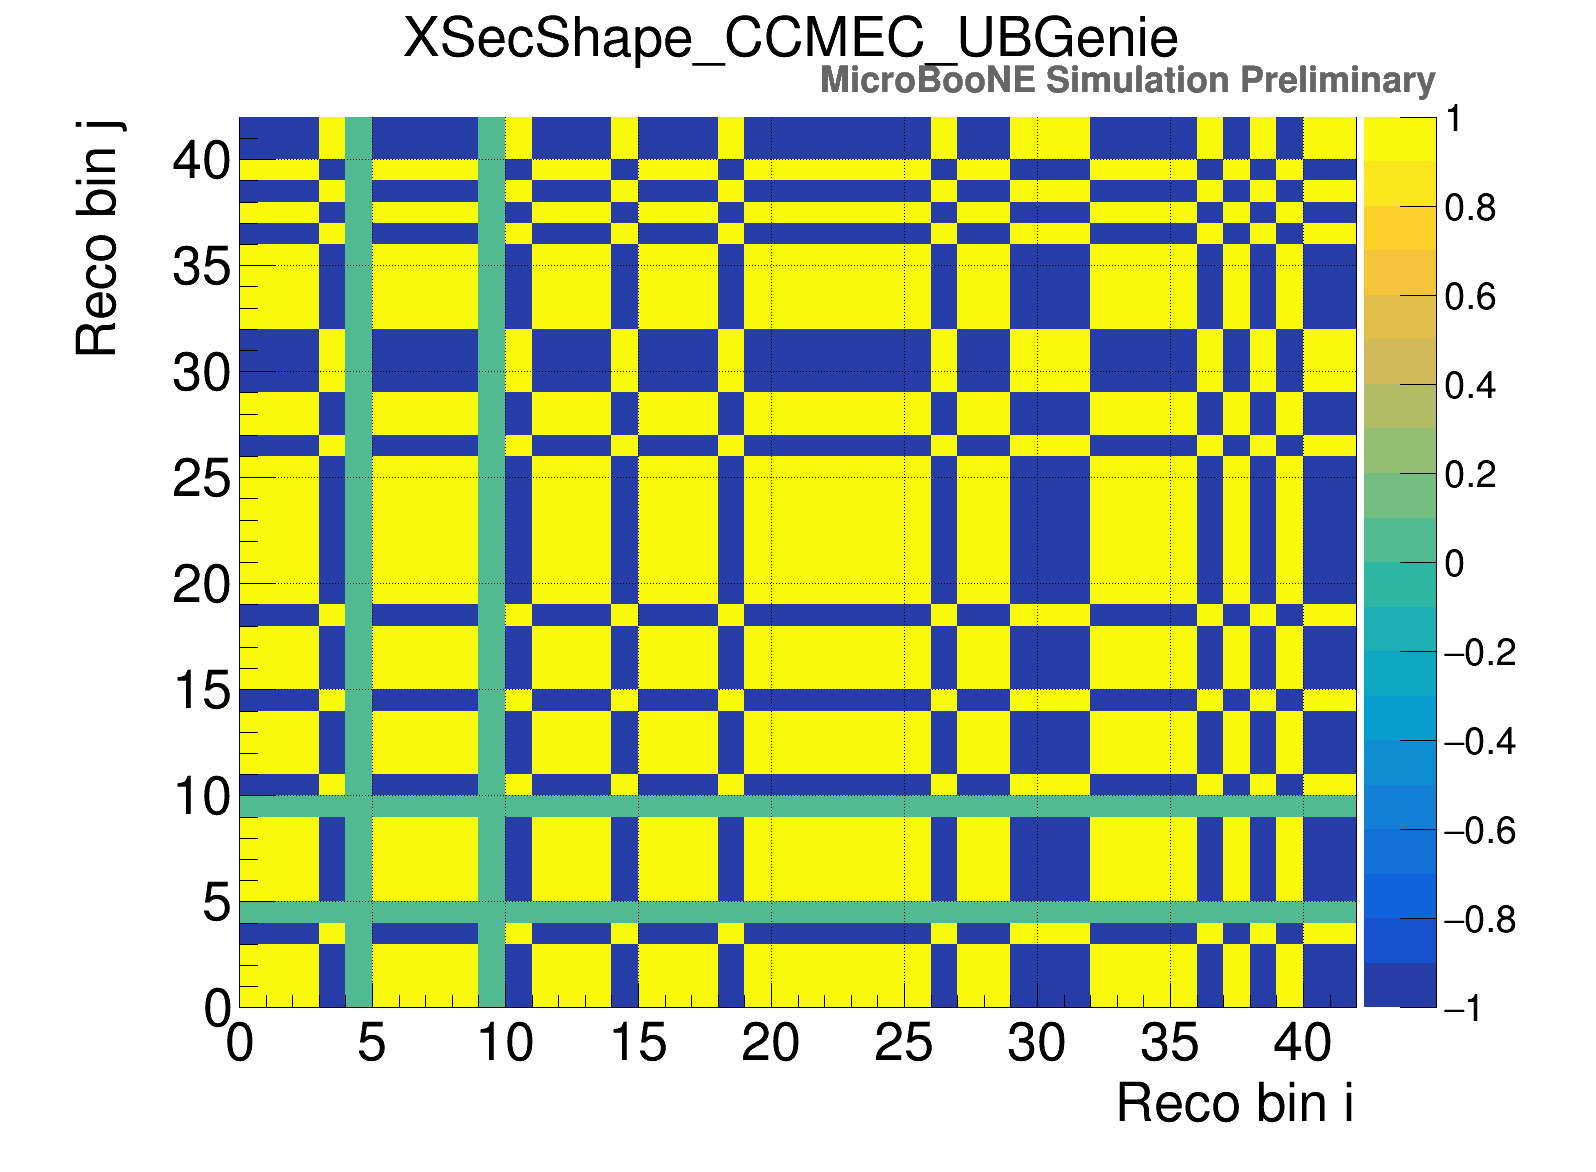

In [22]:
ROOT.gStyle.SetOptTitle(1)

for para in range(num_para):
    ROOT.gStyle.SetPaintTextFormat('0.6g')
    h_covariance = ROOT.TH2D("h_covariance",weight_list[para],sum_bins,0,sum_bins,sum_bins,0,sum_bins)
    for i in range(sum_bins):
        for j in range(sum_bins):
            h_covariance.SetBinContent(i+1,j+1,xsec_corr_matrix_other[para][i,j])
    #h_covariance.SetXTitle("Reco bin i, 7=overflow")
    #h_covariance.SetYTitle("True bin j")
    h_covariance.SetXTitle("Reco bin i")
    h_covariance.SetYTitle("Reco bin j")

    h_covariance.GetYaxis().SetTitleSize(0.05)
    h_covariance.GetYaxis().SetTitleOffset(0.0)
    h_covariance.GetYaxis().SetLabelSize(0.05)
    h_covariance.GetXaxis().SetTitleSize(0.05)
    h_covariance.GetXaxis().SetLabelSize(0.05)
    h_covariance.GetXaxis().SetTitleOffset(1)
    h_covariance.SetLineColor(ROOT.kBlack)
    h_covariance.SetLineWidth(4)
    ROOT.gStyle.SetEndErrorSize(5)
    c1.SetRightMargin(0.15)
    ROOT.gStyle.SetPaintTextFormat('0.4g')

    h_covariance.Draw('colz')
    #_covariance.Draw('same text')
    prelim = draw_sim()
    prelim.Draw()
    c1.Draw()
    c1.SaveAs(outputdir_png + 'h_correlation_othersys'+weight_list[para]+'.png')
    c1.SaveAs(outputdir_root + 'h_correlation_othersys'+weight_list[para]+'.root')
    c1.SaveAs(outputdir_pdf + 'h_correlation_othersys'+weight_list[para]+'.pdf')
    #h_covariance.Write('h_covariance')

Warning in <TROOT::Append>: Replacing existing TH1: h_covariance (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_correlation_othersys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/root/h_correlation_othersys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_correlation_othersys.pdf has been created


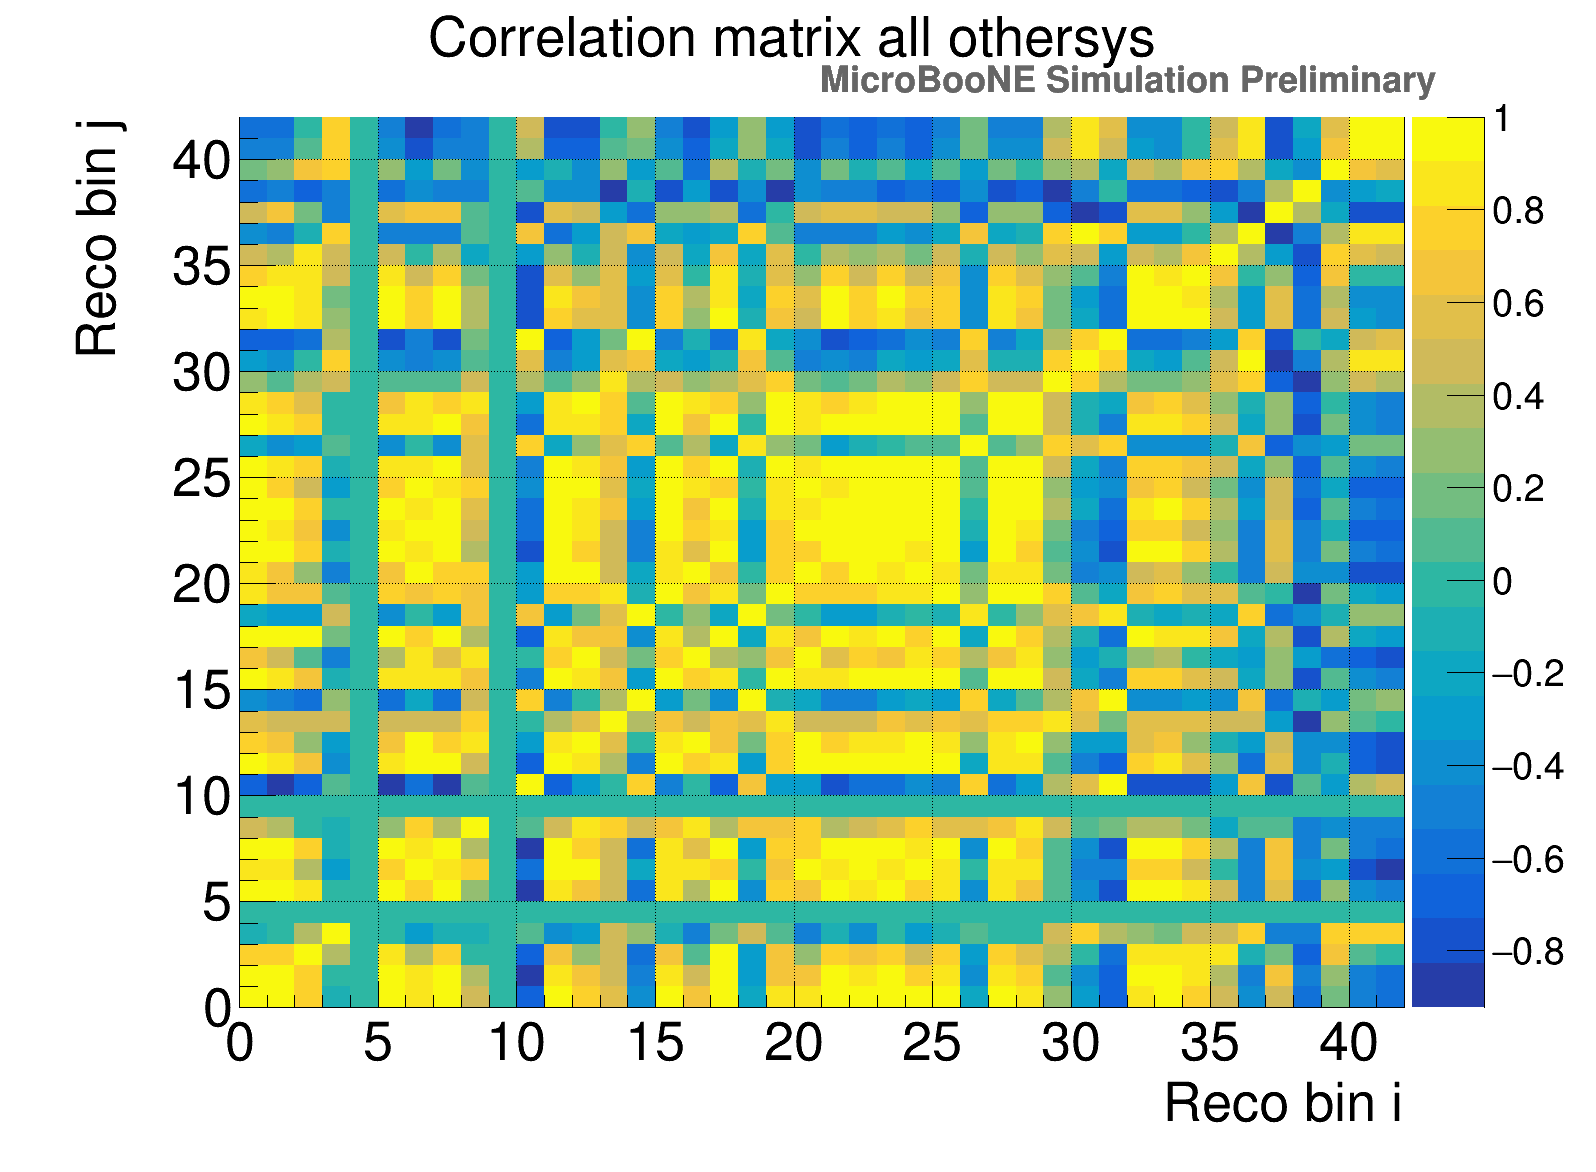

In [23]:
ROOT.gStyle.SetPaintTextFormat('0.6g')
h_covariance = ROOT.TH2D("h_covariance",'Correlation matrix all othersys',sum_bins,0,sum_bins,sum_bins,0,sum_bins)
for i in range(sum_bins):
    for j in range(sum_bins):
        h_covariance.SetBinContent(i+1,j+1,xsec_corr_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")

h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.4g')

h_covariance.Draw('colz')
#h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_correlation_othersys.png")
c1.SaveAs(outputdir_root + "h_correlation_othersys.root")
c1.SaveAs(outputdir_pdf + "h_correlation_othersys.pdf")
#h_covariance.Write('h_covariance')
RootFile = ROOT.TFile(output_filedir+"Other_systematic_2D.root","update");
h_covariance.Write('h_correlation')
RootFile.Close()  

Warning in <TROOT::Append>: Replacing existing TH1: h_covariance (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_frac_othersysAxFFCCQEshape_UBGenie.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/root/h_frac_othersysAxFFCCQEshape_UBGenie.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_correlatioh_frac_othersysn_othersysAxFFCCQEshape_UBGenie.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_covariance (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_frac_othersysDecayAngMEC_UBGenie.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/

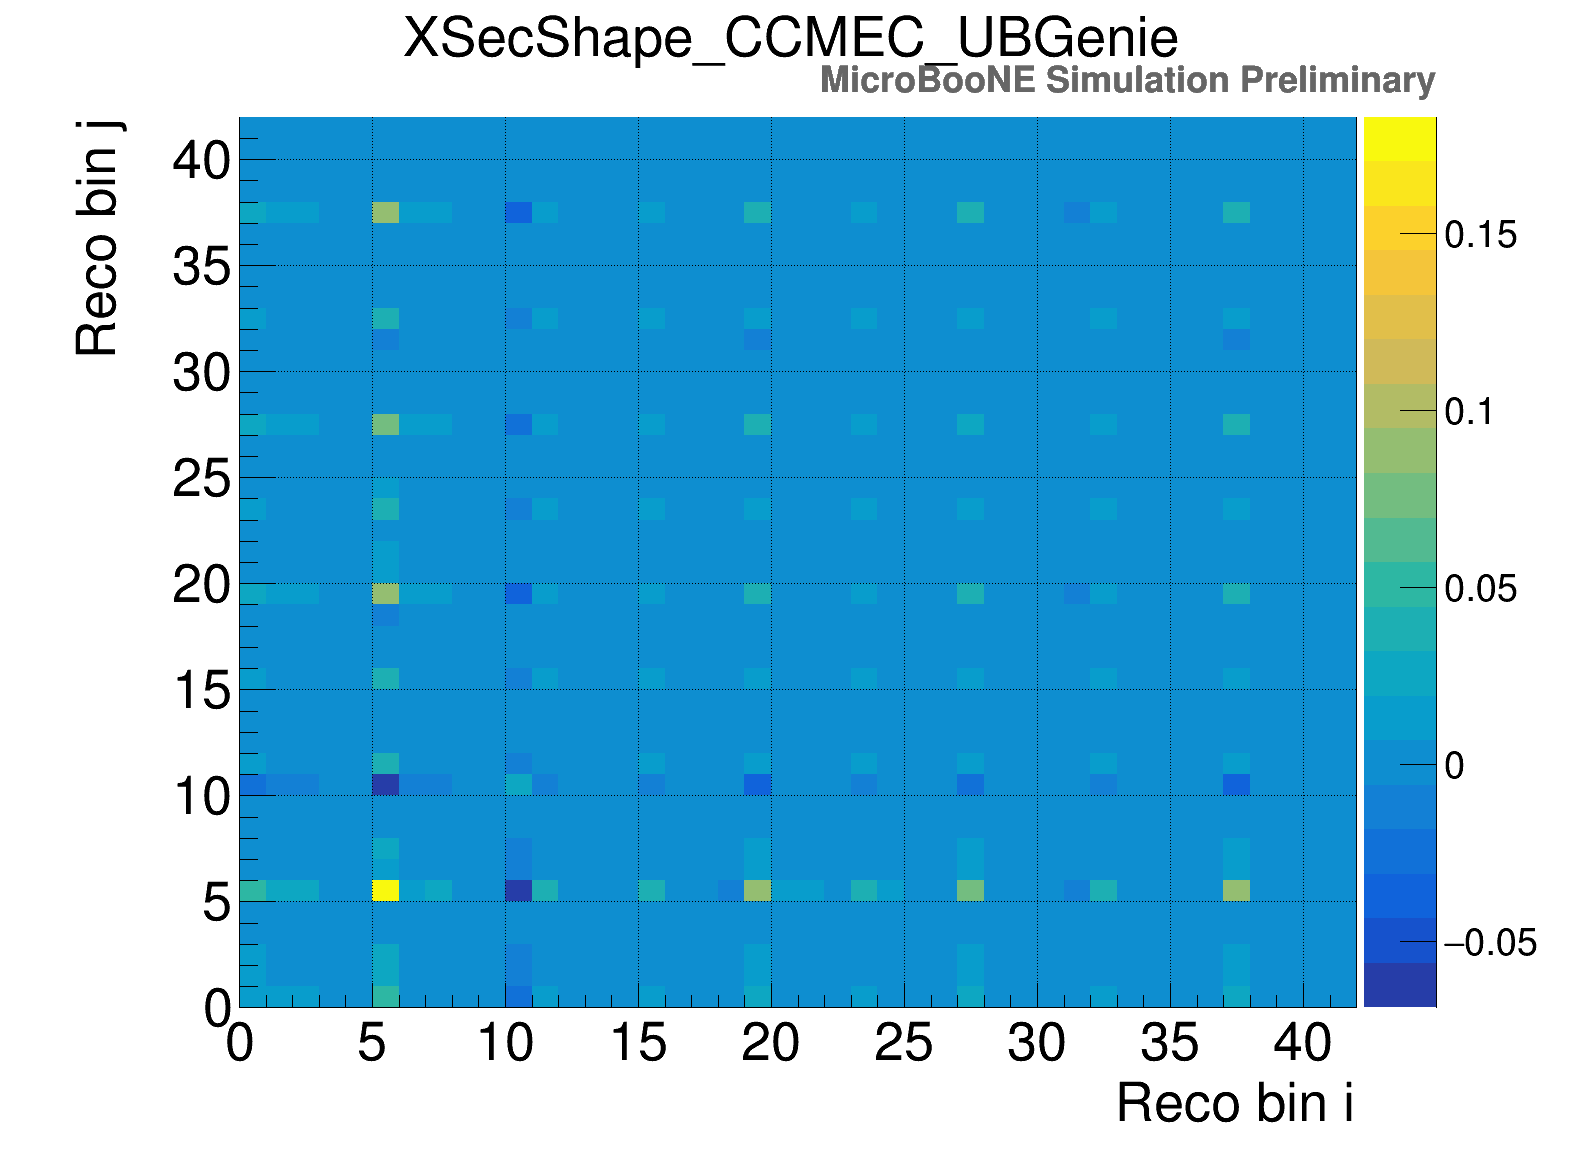

In [24]:
ROOT.gStyle.SetOptTitle(1)

for para in range(num_para):
    ROOT.gStyle.SetPaintTextFormat('0.6g')
    h_covariance = ROOT.TH2D("h_covariance",weight_list[para],sum_bins,0,sum_bins,sum_bins,0,sum_bins)
    for i in range(sum_bins):
        for j in range(sum_bins):
            h_covariance.SetBinContent(i+1,j+1,xsec_frac_matrix_other[para][i,j])
    #h_covariance.SetXTitle("Reco bin i, 7=overflow")
    #h_covariance.SetYTitle("True bin j")
    h_covariance.SetXTitle("Reco bin i")
    h_covariance.SetYTitle("Reco bin j")

    h_covariance.GetYaxis().SetTitleSize(0.05)
    h_covariance.GetYaxis().SetTitleOffset(0.0)
    h_covariance.GetYaxis().SetLabelSize(0.05)
    h_covariance.GetXaxis().SetTitleSize(0.05)
    h_covariance.GetXaxis().SetLabelSize(0.05)
    h_covariance.GetXaxis().SetTitleOffset(1)
    h_covariance.SetLineColor(ROOT.kBlack)
    h_covariance.SetLineWidth(4)
    ROOT.gStyle.SetEndErrorSize(5)
    c1.SetRightMargin(0.15)
    ROOT.gStyle.SetPaintTextFormat('0.4g')

    h_covariance.Draw('colz')
    #_covariance.Draw('same text')
    prelim = draw_sim()
    prelim.Draw()
    c1.Draw()
    c1.SaveAs(outputdir_png + 'h_frac_othersys'+weight_list[para]+'.png')
    c1.SaveAs(outputdir_root + 'h_frac_othersys'+weight_list[para]+'.root')
    c1.SaveAs(outputdir_pdf + 'h_correlatioh_frac_othersysn_othersys'+weight_list[para]+'.pdf')
    #h_covariance.Write('h_covariance')

Warning in <TROOT::Append>: Replacing existing TH1: h_covariance (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_frac_othersys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/root/h_frac_othersys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_frac_othersys.pdf has been created


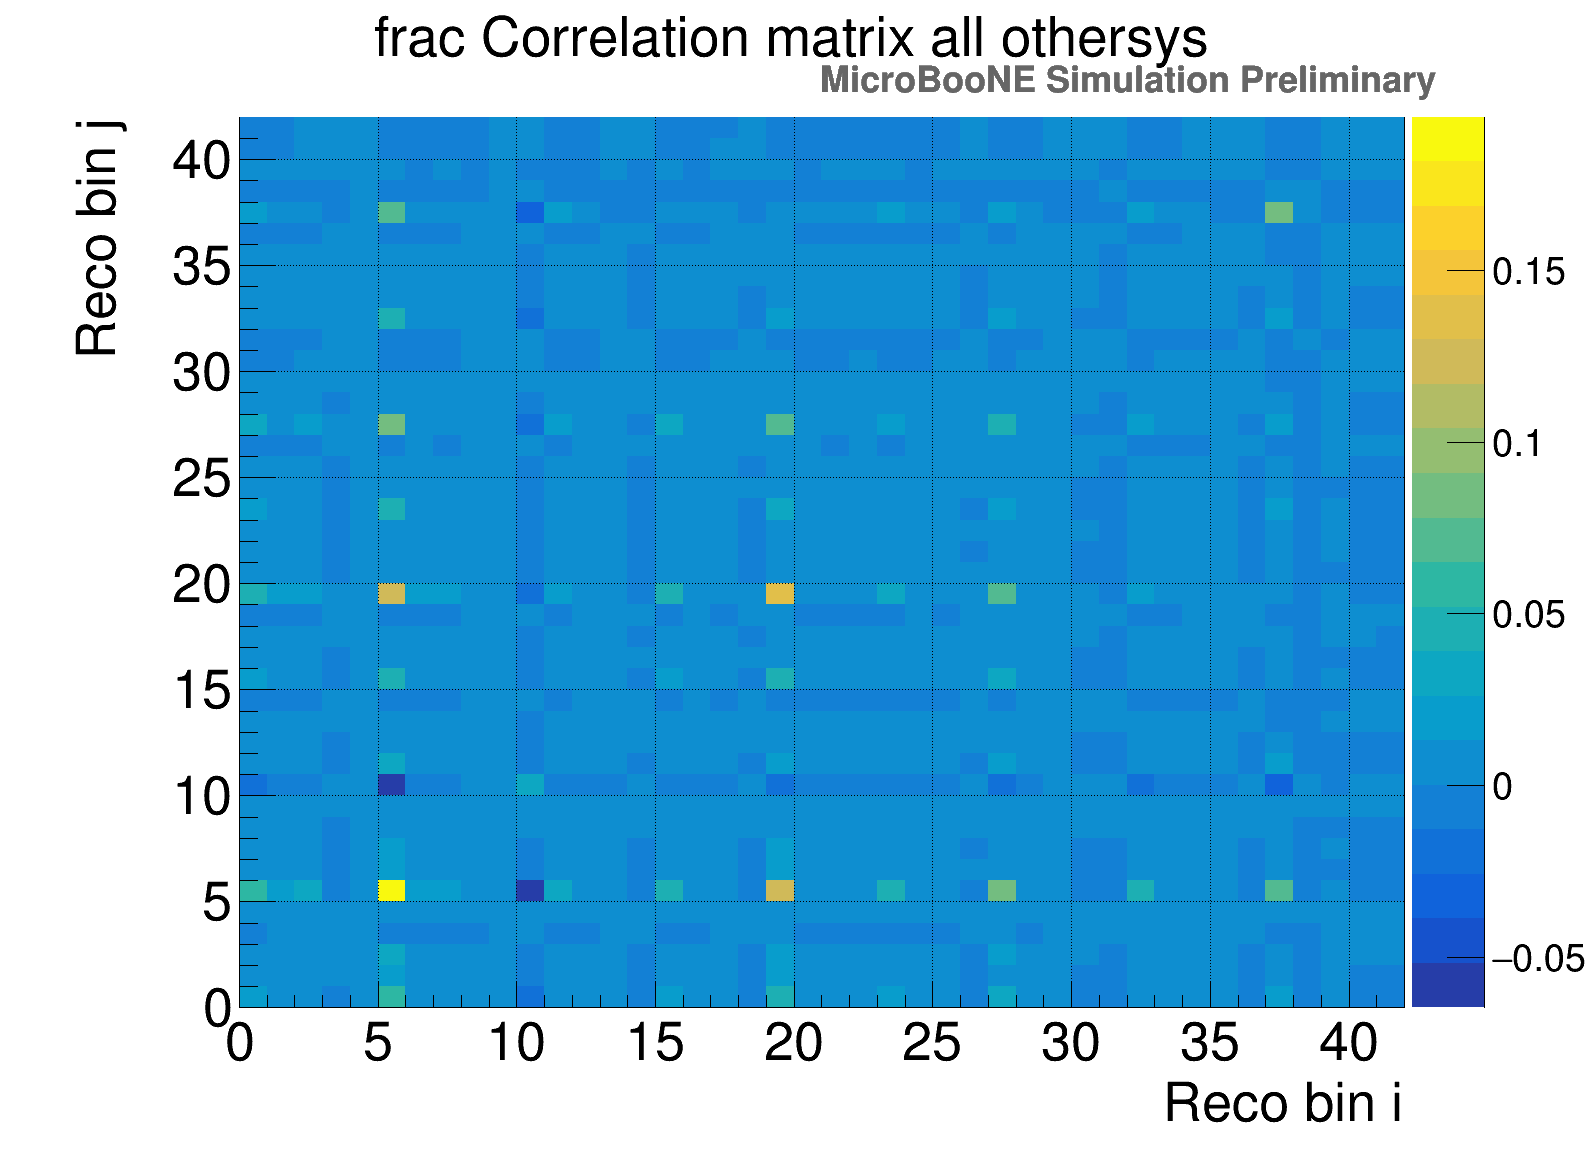

In [25]:
ROOT.gStyle.SetPaintTextFormat('0.6g')
h_covariance = ROOT.TH2D("h_covariance",'frac Correlation matrix all othersys',sum_bins,0,sum_bins,sum_bins,0,sum_bins)
for i in range(sum_bins):
    for j in range(sum_bins):
        h_covariance.SetBinContent(i+1,j+1,xsec_frac_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")

h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.4g')

h_covariance.Draw('colz')
#h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_frac_othersys.png")
c1.SaveAs(outputdir_root + "h_frac_othersys.root")
c1.SaveAs(outputdir_pdf + "h_frac_othersys.pdf")
#h_covariance.Write('h_covariance')
RootFile = ROOT.TFile(output_filedir+"Other_systematic_2D.root","update");
h_covariance.Write('h_frac_covariance')
RootFile.Close()  

In [26]:
# draw all xsec

ROOT.gStyle.SetOptTitle(1)
bin_counter = 0
for t_bin in range(len_theta): #len_theta
    print 'Theta bin: ', t_bin
    legend = ROOT.TLegend(0.55,0.35,0.9,0.9); #LEGEND RIGHT
    h_xsec_this = h_xsec_data[0][0][t_bin].Clone()
    
    c1 = ROOT.TCanvas("c1","c1",1600,1200)
    c1.SetGrid(1)
    c1.SetLeftMargin(0.14)
    c1.SetRightMargin(0.1)
    c1.SetBottomMargin(0.1)

    c1.cd()
    pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
    pad1.SetGrid(1)
    pad1.Draw()
    pad1.cd()
    pad1.SetBottomMargin(0.03);
    pad1.SetTopMargin(0.1)
    legend.AddEntry(h_xsec_data[0][0][t_bin],'CV, stat. err.',"f")
    
    for para in range(num_para):
        for uni in range(2): 
            #bin_counter_2 = 0
            h_xsec_data[para][uni][t_bin].SetLineColorAlpha(para+1+1,0.8)
            if (para+2)==10:
                h_xsec_data[para][uni][t_bin].SetLineColorAlpha(30,0.8)
            h_xsec_data[para][uni][t_bin].SetLineWidth(4)
            if para == 0 and uni == 0:
                h_xsec_data[para][uni][t_bin].SetLineColorAlpha(para+1,0.8)
                h_xsec_this.SetLineColorAlpha(1,0.8)
                h_xsec_this.SetTitle(str(theta_bins[t_bin])+'< cos(#theta^{reco}_{#mu}) <'+str(theta_bins[t_bin+1]))
                h_xsec_this.SetXTitle("p^{reco}_{#mu} [GeV]")
                h_xsec_this.SetYTitle('#frac{#sigma^{2}}{dp_{#mu} dcos(#theta)} \t [10^{-38} #frac{cm^{2}}{GeV Nucleon}]')
                h_xsec_this.SetMaximum(-1111)
                h_xsec_this.SetMaximum( h_xsec_this.GetMaximum()*1.5)
                h_xsec_this.GetYaxis().SetLabelSize(0.05);
                h_xsec_this.GetYaxis().SetTitleSize(0.05);
                h_xsec_this.GetYaxis().SetTitleOffset(0.8);
                h_xsec_this.GetXaxis().SetLabelOffset(999);
                h_xsec_this.GetXaxis().SetTitleOffset(999);
                h_xsec_this.GetXaxis().SetLabelSize(0);
                h_xsec_this.GetXaxis().SetTitleSize(0);
                for m_bin in range(len_mom[t_bin]):
                    h_xsec_this.SetBinError(m_bin+1,math.sqrt(cov_matrix[bin_counter][bin_counter]))
                    #print bin_counter, math.sqrt(cov_matrix[bin_counter][bin_counter]),  math.sqrt(cov_matrix[bin_counter][bin_counter]/xsec_cv_vec[bin_counter]/xsec_cv_vec[bin_counter])
                    bin_counter +=1
                h_xsec_this.Draw('E1')
            else:
                h_xsec_data[para][uni][t_bin].Draw('hist same')
        legend.AddEntry(h_xsec_data[para][uni][t_bin],weight_list[para],"f")
    h_xsec_this.Draw('E1 same')
    legend.Draw()
    #bin_counter += len_mom[t_bin]
    #print bin_counter

    
    c1.cd()
    h_xsec_data[0][0][t_bin].GetXaxis().SetLabelOffset(0);
    h_xsec_data[0][0][t_bin].GetXaxis().SetTitleOffset(0);
    pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
    pad2.SetGrid(1)
    pad2.SetTopMargin(0.04)
    pad2.SetBottomMargin(0.4)
    pad2.Draw()
    pad2.cd()
    h_files2 = []
    #ROOT.gStyle.SetOptTitle(0)
    
    for para in range(num_para):
        h_files2.append([])
        for uni in range(2): 
            
            h_files2[para].append(h_xsec_data[para][uni][t_bin].Clone())
            h_files2[para][uni].SetLineColorAlpha(para+1+1,0.8)
            h_files2[para][uni].SetTitle(' ')
            if (para+1+1)==10:
                h_files2[para][uni].SetLineColorAlpha(30,0.8)
            if para ==0 and uni == 0:
                h_files2[para][uni].SetLineColorAlpha(para+1,0.8)
                for m_bin in range(len_mom[t_bin]):
                    h_files2[para][uni].SetBinError(m_bin+1,1e-80)
                h_files2[para][uni].Divide(h_xsec_this)
                #for m_bin in range(len_mom[t_bin]):
                    #print 'Error: ',m_bin,' - ', h_files2[i].GetBinError(m_bin+1)
                h_files2[para][uni].SetYTitle('Data/(Ext+MC)')
                h_files2[para][uni].GetYaxis().SetTitleSize(0.1)
                h_files2[para][uni].GetYaxis().SetTitleOffset(0.3)
                h_files2[para][uni].GetYaxis().SetLabelSize(0.07)

                h_files2[para][uni].GetXaxis().SetTitleSize(0.15)
                h_files2[para][uni].GetXaxis().SetLabelSize(0.15)
                h_files2[para][uni].GetXaxis().SetTitleOffset(1)
                h_files2[para][uni].SetMinimum(-1111)
                h_files2[para][uni].SetMaximum(-1111)
                h_files2[para][uni].Draw('E1 hist')
            else:
                h_files2[para][uni].Divide(h_xsec_this)
                h_files2[para][uni].Draw('hist same')
    h_files2[0][0].Draw('E1 same')
    c1.Draw()
    
    c1.SaveAs(outputdir_png + 'h_xsec_2D_'+str(t_bin)+'_syserr.png')
    #c1.SaveAs(outputdir_root + 'h_xsec_2D_'+str(t_bin)+'_syserr.root')
    c1.SaveAs(outputdir_pdf + 'h_xsec_2D_'+str(t_bin)+'_syserr.pdf')

    c1.Draw()
#ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Theta bin:  0
Theta bin:  1
Theta bin:  2
Theta bin:  3
Theta bin:  4
Theta bin:  5
Theta bin:  6
Theta bin:  7
Theta bin:  8


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_xsec_2D_0_syserr.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_xsec_2D_0_syserr.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/png/h_xsec_2D_1_syserr.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_mar18/pdf/h_xsec_2D_1_syserr.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_other_2D_2_

In [27]:
# close the root file with all the histos
RootFile.Close()